<a href="https://colab.research.google.com/github/Walbyq/timeseries-forecast/blob/main/beer_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Установка библиотек

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.4 MB/s eta 0:00:00


# Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pmdarima import auto_arima
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, train_test_split, KFold

from datetime import datetime, timedelta
from tabulate import tabulate

# Загрузка файлов

In [ ]:
# Подключение к Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
path = '/content/drive/MyDrive/data/data_for_test_arch'

# Просмотр файлов в папке
files = os.listdir(path)
print(files)

['beer_sales_data.parquet', 'ana_sales_data.parquet', 'cig_sales_data.parquet', 'demographic_data.parquet', 'cig_upc.parquet', 'ana_upc.parquet', 'beer_upc.parquet']


Для анализа возьмем набор данных о продажах пива

In [ ]:
# Загрузка данных
df = pd.read_parquet(f"{path}/beer_sales_data.parquet")
upc_df = pd.read_parquet(f"{path}/beer_upc.parquet", columns=['upc', 'descrip'])

# Анализ данных

In [ ]:
# Функция для красивого отображения датафреймов
def tabulate_df(df):
    return print(tabulate(df, headers='keys', tablefmt='psql'))

# Вывод информации о датафрейме
print("="*20, "Данные о продажах пива:", "="*20)
tabulate_df(df.head())
tabulate_df(upc_df.head())
print("\nРазмерность:", df.shape)
print("\nПустые значения:")
print(df.isnull().sum())
print("\nСтатистическое описание:")
print(tabulate_df(df.describe()))
print("\nОсновная информация:")
print(df.info())

==================== Данные о продажах пива: ====================
+----+---------+-------+--------+--------+-------+---------+--------+
|    |   store |   upc |   week |   move |   qty |   price | sale   |
|----+---------+-------+--------+--------+-------+---------+--------|
|  0 |       2 |   294 |    298 |     11 |     1 |    2.62 |        |
|  1 |       2 |   294 |    299 |      9 |     1 |    2.51 |        |
|  2 |       2 |   294 |    300 |      6 |     1 |    2.49 |        |
|  3 |       2 |   294 |    301 |      5 |     1 |    2.99 |        |
|  4 |       2 |   294 |    302 |      1 |     1 |    2.49 |        |
+----+---------+-------+--------+--------+-------+---------+--------+
+----+-------+----------------------+
|    |   upc | descrip              |
|----+-------+----------------------|
|  0 |   294 | BEER LIMIT           |
|  1 |   307 | HEINEKEN KINGSIZE CA |
|  2 |   710 | BUDWEISER BEER       |
|  3 |   711 | BUDWEISER DRY BEER   |
|  4 |   712 | BUDWEISER LIGHT BEER |


Удалим ненужные строки, в которых не было продаж

In [ ]:
df = df[df['move'] != 0]

Столбец *sale* содержит пустые значения, исправим это, заменив пустые строки на 0, если товар был преобретен без скидки и на 1, если товар был со скидкой. Также удалим недели с нулевыми продажами

In [ ]:
df['sale'] = df['sale'].apply(lambda x: False if x is None else True)

Из статистического описания таблицы *beer_sales_data* мы видим, что в ней присутствуют значения *qty* = 2 (кол-во предметов, упакованных вместе). Рассмотрим эти значения:

In [ ]:
# Фильтрация по количеству 'qty' равному 2
print("Продажи с параметром 'qty' = 2:")
filtered_qty = df[df['qty'] == 2]
print(tabulate_df(filtered_qty.head()))

# Фильтрация по UPC
print("\nПрочие продажи одного из перечисленных товаров:")
filtered_upc = df[df['upc'] == 8797502650]
print(tabulate_df(filtered_upc.head()))

Продажи с параметром 'qty' = 2:
+---------+---------+------------+--------+--------+-------+---------+--------+
|         |   store |        upc |   week |   move |   qty |   price | sale   |
|---------+---------+------------+--------+--------+-------+---------+--------|
|  980319 |      95 | 3410015505 |    140 |    142 |     2 |       5 | True   |
| 1083765 |      95 | 3410017505 |    140 |    769 |     2 |       5 | True   |
| 1342399 |      95 | 3410057505 |    140 |    578 |     2 |       5 | False  |
| 3776134 |      14 | 8797502650 |    151 |      1 |     2 |       3 | True   |
| 3776135 |      14 | 8797502650 |    152 |     13 |     2 |       3 | False  |
+---------+---------+------------+--------+--------+-------+---------+--------+
None

Прочие продажи одного из перечисленных товаров:
+---------+---------+------------+--------+--------+-------+---------+--------+
|         |   store |        upc |   week |   move |   qty |   price | sale   |
|---------+---------+------------+

Видим, что цена на них выше, чем при *qty* = 1, даже при условии, что они преобретены по скидке. Делаем вывод, что цена указана не за единицу товара, а за упаковку. Приведем все значения к *qty* = 1:

In [ ]:
# Меняем количество проданного товара и цену
df['move'] = df['move'] * df['qty']
df['price'] = df['price'] / df['qty']

In [ ]:
# Удаляем ненужные столбцы
df = df.drop(columns=['qty','store', 'upc'])
tabulate_df(df.head())

+----+--------+--------+---------+--------+
|    |   week |   move |   price | sale   |
|----+--------+--------+---------+--------|
|  0 |    298 |     11 |    2.62 | False  |
|  1 |    299 |      9 |    2.51 | False  |
|  2 |    300 |      6 |    2.49 | False  |
|  3 |    301 |      5 |    2.99 | False  |
|  4 |    302 |      1 |    2.49 | False  |
+----+--------+--------+---------+--------+


Каждому порядковому номеру недели поставим в соответствие дату. Даты возьмем из мануала https://www.chicagobooth.edu/research/kilts/research-data/-/media/enterprise/centers/kilts/datasets/dominicks-dataset/dominicks-manual-and-codebook_kiltscenter

In [ ]:
# Начальная дата первой недели
start_date = datetime.strptime('09/14/1989', '%m/%d/%Y')

# Функция для получения даты начала недели
def get_start_date_of_week(week_num):
    return start_date + timedelta(weeks=week_num - 1)

# Добавляем дату
df['date'] = df['week'].apply(get_start_date_of_week)

print("Объем продаж пива в неделю, начиная с указанной даты:")
tabulate_df(df.head())

Объем продаж пива в неделю, начиная с указанной даты:
+----+--------+--------+---------+--------+---------------------+
|    |   week |   move |   price | sale   | date                |
|----+--------+--------+---------+--------+---------------------|
|  0 |    298 |     11 |    2.62 | False  | 1995-05-25 00:00:00 |
|  1 |    299 |      9 |    2.51 | False  | 1995-06-01 00:00:00 |
|  2 |    300 |      6 |    2.49 | False  | 1995-06-08 00:00:00 |
|  3 |    301 |      5 |    2.99 | False  | 1995-06-15 00:00:00 |
|  4 |    302 |      1 |    2.49 | False  | 1995-06-22 00:00:00 |
+----+--------+--------+---------+--------+---------------------+


Агрегируем данные по параметрам

In [ ]:
# Задаем недели праздников
holiday_dates = {
    '4th of July': [95, 147, 199, 251, 303, 356],
    'Labor Day': [103, 156, 208, 260, 312, 364],
    'Halloween': [112, 164, 216, 268, 320, 372],
    'Thanksgiving': [116, 168, 220, 272, 324, 377],
    'Christmas': [119, 172, 224, 276, 328, 380],
    'New Year': [120, 173, 225, 277, 329, 381],
    'Presidents Day': [128, 180, 232, 284, 336, 389],
    'Easter': [133, 185, 238, 289, 341, 393],
    'Memorial Day': [141, 194, 256, 298, 350],
}

# Функция определения сезона на основе месяца
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Autumn'

# Функция для определения праздника или обычного дня
def get_holiday(week):
    for holiday_name, weeks in holiday_dates.items():
        if week in weeks: return holiday_name
    return 'Ordinary'

# Функция для агрегации по различным параметрам
def aggregate_sales(df, col):
    # Агрегация по заданному столбцу
    sales = df.groupby(col)['move'].sum().reset_index()
    count = df.groupby(col)['date'].count().reset_index(name='count')

    # Объединение данных
    aggregated = sales.merge(count, on=col)

    # Расчет средней продажи
    aggregated['avg_move'] = aggregated['move'] / aggregated['count']

    return aggregated

# Добавление столбцов недели и праздника
df['season'] = df['date'].dt.month.apply(get_season)
df['holiday'] = df['week'].apply(get_holiday)

# Агрегация
price_sales = aggregate_sales(df, 'price')
sale_sales = aggregate_sales(df, 'sale')
season_sales = aggregate_sales(df, 'season')
holiday_sales = aggregate_sales(df, 'holiday')

# Вывод результатов
print("Агрегация по цене:")
tabulate_df(price_sales.head())
print("\nАгрегация по скидке:")
tabulate_df(sale_sales.head())
print("\nАгрегация по сезону:")
tabulate_df(season_sales.head())
print("\nАгрегация по празднику:")
tabulate_df(holiday_sales.head(20))

Построим графики распределения

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(14, 5))
plt.suptitle('Распределение по параметрам')

# Гистограмма средних продаж по цене
sns.histplot(price_sales['move'], bins=10, ax=axes[0])
axes[0].set_title('Цена')

# График средних продаж по наличию скидки
sns.barplot(x='sale', y='move', data=sale_sales, ax=axes[1])
axes[1].set_title('Наличие скидки')

# График средних продаж по сезонам
sns.barplot(x='season', y='move', data=season_sales, ax=axes[2])
axes[2].set_title('Сезон')

# График средних продаж по сезонам
sns.barplot(x='holiday', y='move', data=holiday_sales, ax=axes[3])
axes[3].set_title('Праздник')
# Поворот подписей
axes[3].set_xticks(range(len(holiday_sales['holiday'])))
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

Проанализируем зависимость спроса от цены, скидки, сезона и праздника

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(14, 5))
plt.suptitle('Средние продажи по различным параметрам')

# Гистограмма средних продаж по цене
sns.histplot(price_sales['avg_move'], bins=10, ax=axes[0])
axes[0].set_title('Цена')

# График средних продаж по наличию скидки
sns.barplot(x='sale', y='avg_move', data=sale_sales, ax=axes[1])
axes[1].set_title('Наличие скидки')

# График средних продаж по сезонам
sns.barplot(x='season', y='avg_move', data=season_sales, ax=axes[2])
axes[2].set_title('Сезон')

# График средних продаж по сезонам
sns.barplot(x='holiday', y='avg_move', data=holiday_sales, ax=axes[3])
axes[3].set_title('Праздник')

# Поворот подписей
axes[3].set_xticks(range(len(holiday_sales['holiday'])))
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

По графикам видно:
- При увеличении цены спрос падает
- Сниженная цена значительно привлекает покупателей
- В теплые сезоны люди хотят пить больше пива
- Спрос значительно увеличивается на День Независимости, немного на День Труда и День Памяти, а в остальные праздники не сильно отклоняется от продаж в обычные дни

In [ ]:
tabulate_df(df.head())
print("Строк: ", df.shape[0])

In [ ]:
# Агрегирование данных
df = df.groupby('date').agg({
    'move': 'sum',
    'price': 'mean',
    'sale': 'mean',
    'season': 'first',
    'holiday': 'first',
    'week': 'first'
}).reset_index()

tabulate_df(df.head())
print("Строк: ", df.shape[0])

Восполним недостающие даты

In [ ]:
# Определяем минимальное и максимальное значение даты
min_date = df['date'].min()
max_date = df['date'].max()

# Создаем полный диапазон дат от min до max с шагом в неделю
full_range = pd.date_range(start=min_date, end=max_date, freq='W-Thu').to_frame(index=False, name='date')

# Объединяем с оригинальным датафреймом
df = full_range.merge(df, on='date', how='left')

# Заполняем пропуски
df['move'] = df['move'].fillna(df['move'].mean())
df['price'] = df['price'].fillna(df['price'].mean())
df['sale'] = df['sale'].fillna(df['sale'].mean())
df['season'] = df['season'].fillna(df['date'].dt.month.apply(get_season))
df['holiday'] = df['holiday'].fillna(df['week'].apply(get_holiday))

# Удаляем столбец 'week'
df = df.drop(columns=['week'])

tabulate_df(df.head())
print("Строк после добавления пропущенных дат: ", df.shape[0])

Создадим функцию для подсчета средней абсолютной процентной ошибки:

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Предобработка данных

Выполним нормализацию и категориализацию данных, а также изменим тип категориальных переменных на int, так как SARIMAX не принимает переменные различных типов

In [ ]:
# Нормализация числовых переменных
scaler = MinMaxScaler()
df[['price', 'sale']] = scaler.fit_transform(df[['price', 'sale']])

# One-hot encoding категориальных переменных
df = pd.get_dummies(df, columns=['season', 'holiday'], drop_first=True)

# Меняем столбцы типа bool на int для SARIMAX
categorical_cols = df.select_dtypes(include=['bool']).columns
df[categorical_cols] = df[categorical_cols].astype(int)

tabulate_df(df.head())

# SARIMA

In [ ]:
# Установка даты в качестве индекса
indexed_df = df.set_index('date')

# Задаем недельную частоту, начиная с четверга
indexed_df.index.freq = 'W-THU'

# Задаем периодичность (52 недели в году)
forecast_periods = 52

Построим наш временной ряд:

In [ ]:
# Функция для визуализации временных рядов
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [ ]:
amount0 = indexed_df['move']
tsplot(amount0, 120)

Видим, что ряд нестационарен, так как коэффициент Дики-Фуллера > 0.05

Приведем ряд к стационарному, используя сдвиги:

In [ ]:
amount1 = (amount0 - amount0.shift(52)).dropna() # Избавляемся от сезонности
amount2 = (amount1 - amount1.shift(1)).dropna()  # Избавляемся от краткосрочных колебаний
tsplot(amount2, 120)

Исходя из графиков автокорреляции имеем параметры для SARIMA:

- p = 2
- d = 1
- q = 1
- P = 1
- D = 1
- Q = 1
- s = 52

In [ ]:
# Задаем параметры модели вручную (я заменила на параметры из auto_arima)
p, d, q = 1, 1, 1
P, D, Q, s = 2, 0, 0, 52

In [ ]:
# # Автоматический подбор параметров SARIMA
# arima_model = auto_arima(indexed_df['move'], seasonal=True,
#                    m=forecast_periods, stepwise=True, trace=True)

# # Извлекаем параметры
# p = arima_model.order[0]
# d = arima_model.order[1]
# q = arima_model.order[2]

# P = arima_model.seasonal_order[0]
# D = arima_model.seasonal_order[1]
# Q = arima_model.seasonal_order[2]
# s = arima_model.seasonal_order[3]

# # Вывод лучшего результата
# print(arima_model.summary())

Обучим модель SARIMAX

In [ ]:
# Определение модели SARIMAX
arima_model = SARIMAX(indexed_df['move'],
                      exog=indexed_df.drop(columns=['move']),
                      order=(p, d, q),
                      seasonal_order=(P, D, Q, s))

# Обучение модели
results = arima_model.fit()

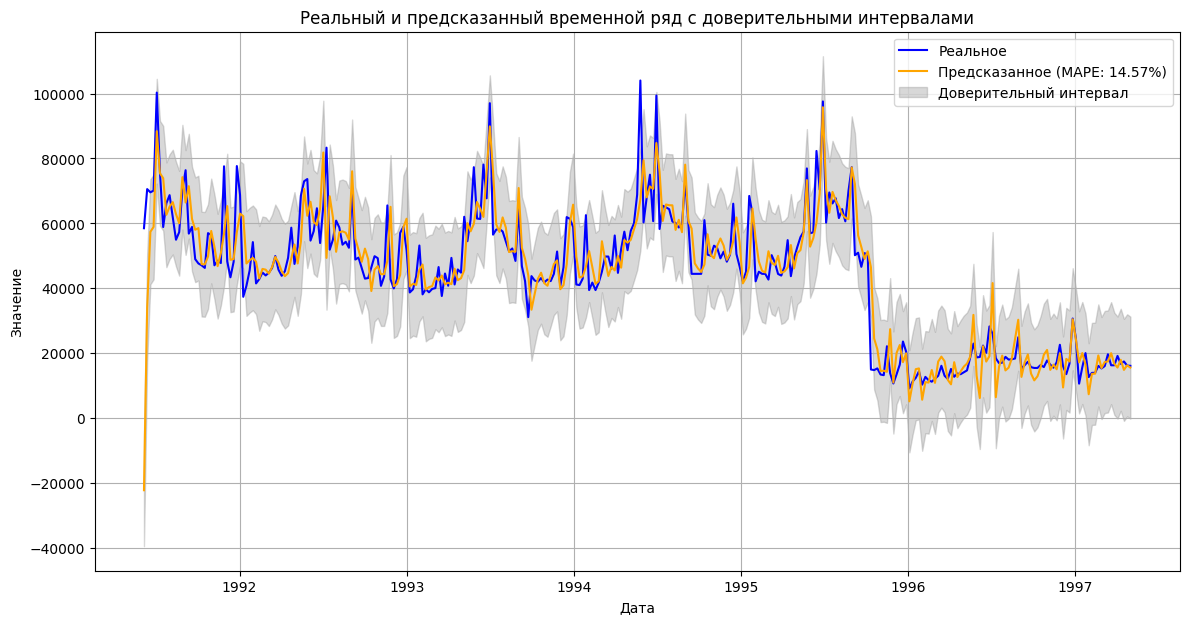

In [ ]:
# Оценка обучения
predictions = results.predict(start=indexed_df.index[0], end=indexed_df.index[-1])

# Получение стандартных ошибок предсказаний
predictions_se = results.get_prediction(start=indexed_df.index[0], end=indexed_df.index[-1])
predictions_summary_frame = predictions_se.summary_frame(alpha=0.05)

# Рассчет ошибки
error = mean_absolute_percentage_error(indexed_df['move'], predictions)

# График реального и предсказанного временного ряда с границами
plt.figure(figsize=(14, 7))
plt.plot(indexed_df.index, indexed_df['move'], label="Реальное", color='blue')
plt.plot(predictions.index, predictions, label=f"Предсказанное (MAPE: {error:.2f}%)", color='orange')

# Добавление доверительных интервалов
plt.fill_between(predictions_summary_frame.index,
                 predictions_summary_frame['mean_ci_lower'],
                 predictions_summary_frame['mean_ci_upper'],
                 color='gray', alpha=0.3, label='Доверительный интервал')

plt.legend()
plt.title("Реальный и предсказанный временной ряд с доверительными интервалами")
plt.xlabel("Дата")
plt.ylabel("Значение")
plt.grid()
plt.show()

Прогнозируем спрос на год вперед

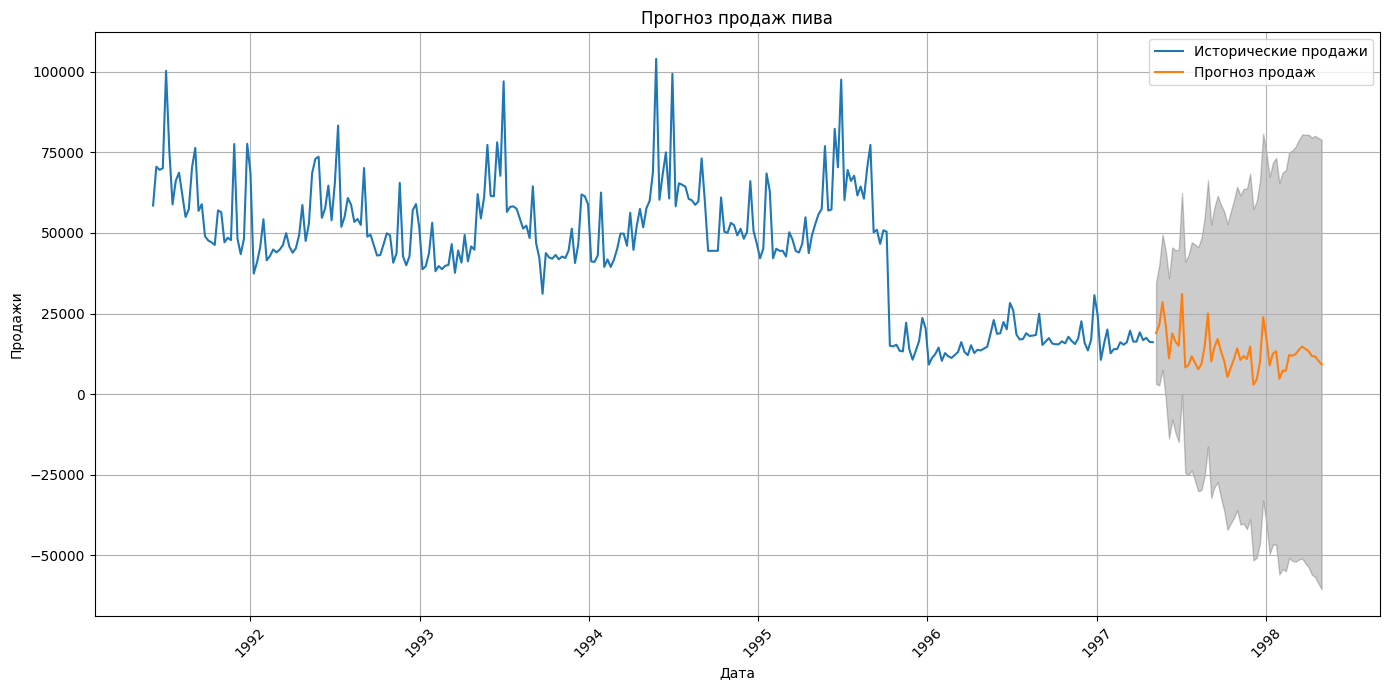

In [ ]:
# Создание future_exog на основе последнего года
exog = indexed_df.drop(columns=['move']).tail(forecast_periods)

# Прогнозирование
forecast = results.get_forecast(steps=forecast_periods, exog=exog)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Создание диапазона дат для прогноза
last_date = indexed_df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(weeks=1), periods=forecast_periods, freq='W-Thu')

# Визуализация прогноза
plt.figure(figsize=(14, 7))
plt.plot(indexed_df.index, indexed_df['move'], label="Исторические продажи")
plt.plot(forecast_index, forecast_mean.values, label="Прогноз продаж")
plt.fill_between(forecast_index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='k', alpha=0.2)
plt.title("Прогноз продаж пива")
plt.xlabel("Дата")
plt.ylabel("Продажи")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Linear Regression

Для обучения модели линейной регрессии необходимо создать дополнительные столбцы с задержанными значениями

In [ ]:
# Создание нового датафрейма
lagged_df = df.drop(columns=['date']).copy()

# Для столбца move добавляем задержки
vals = list(range(1, 11)) + list(range(49, 54))
for i in vals:
    lagged_df[f"lag_{i}"] = lagged_df['move'].shift(i)

# Нормализация лагов
scaler = MinMaxScaler()
lag_columns = [f'lag_{i}' for i in vals]
lagged_df[lag_columns] = scaler.fit_transform(lagged_df[lag_columns])

# Проверка результата
tabulate_df(lagged_df)

+-----+----------+-------------+-----------+-----------------+-----------------+-----------------+---------------------+------------------+---------------------+---------------------+------------------------+--------------------+--------------------+--------------------------+------------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|     |     move |       price |      sale |   season_Spring |   season_Summer |   season_Winter |   holiday_Christmas |   holiday_Easter |   holiday_Halloween |   holiday_Labor Day |   holiday_Memorial Day |   holiday_New Year |   holiday_Ordinary |   holiday_Presidents Day |   holiday_Thanksgiving |       lag_1 |       lag_2 |       lag_3 |       lag_4 |       lag_5 |       lag_6 |       lag_7 |       lag_8 |       lag_9 |      lag_10 |      lag_49 |      lag_50 |      lag_51 |   

Разделим столбцы на признаки и целевую переменную

In [ ]:
# Разделение признаков и целевой переменной
X = lagged_df.drop(columns=['move']).dropna()
y = lagged_df['move'][X.index]

Обучим модель линейной регрессии

In [ ]:
# Добавление константы для модели
X = sm.add_constant(X)

# Определение модели линейной регрессии
lr_model = sm.OLS(y, X)

# Обучение модели
results = lr_model.fit()

In [ ]:
print(X, y)

     const     price      sale  season_Spring  season_Summer  season_Winter  \
53     1.0  0.472081  0.189054              0              1              0   
54     1.0  0.348853  0.339803              0              1              0   
55     1.0  0.323526  0.405146              0              1              0   
56     1.0  0.349305  0.413183              0              1              0   
57     1.0  0.366054  0.443735              0              1              0   
..     ...       ...       ...            ...            ...            ...   
304    1.0  0.895565  0.557443              1              0              0   
305    1.0  0.844502  0.566652              1              0              0   
306    1.0  0.861902  0.526659              1              0              0   
307    1.0  0.898748  0.442985              1              0              0   
308    1.0  0.970108  0.312999              1              0              0   

     holiday_Christmas  holiday_Easter  holiday_Hal

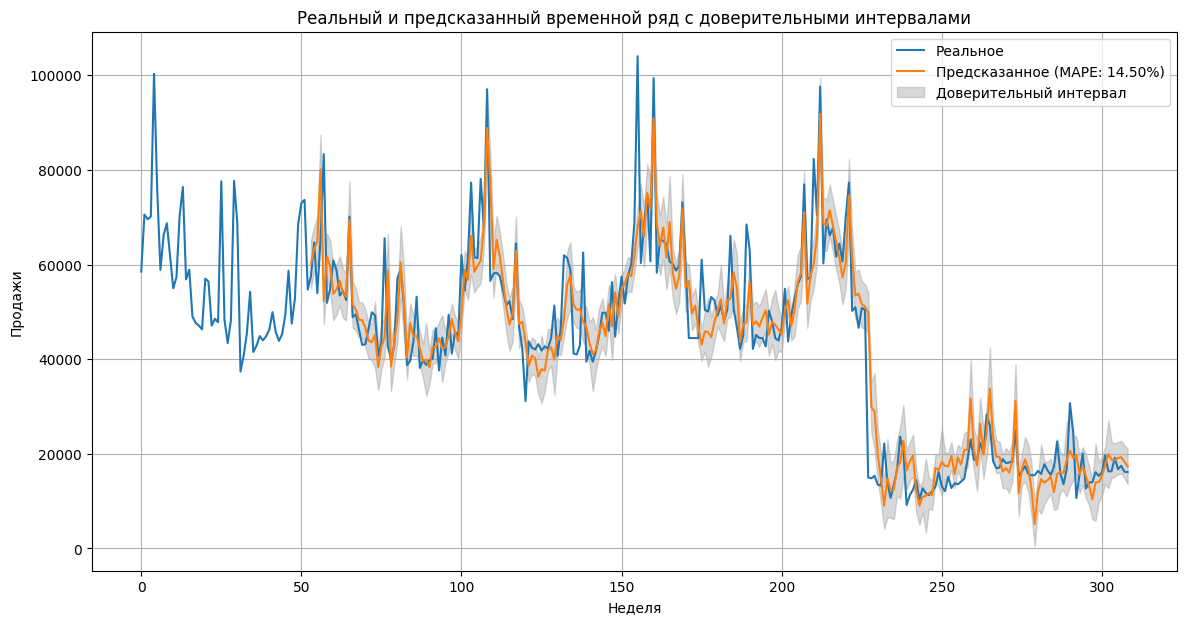

In [ ]:
# Оценка обучения
predictions = results.predict(X)

# Получение стандартных ошибок предсказаний
predictions_se = results.get_prediction(X)
predictions_summary_frame = predictions_se.summary_frame(alpha=0.05)

# Рассчет ошибки
error = mean_absolute_percentage_error(lagged_df['move'].loc[X.index], predictions)

# График реального и предсказанного временного ряда с границами
plt.figure(figsize=(14, 7))
plt.plot(lagged_df.index, lagged_df['move'], label="Реальное")
plt.plot(lagged_df.index[X.index], predictions, label=f"Предсказанное (MAPE: {error:.2f}%)")

# Добавление доверительных интервалов
plt.fill_between(predictions_summary_frame.index,
                 predictions_summary_frame['mean_ci_lower'],
                 predictions_summary_frame['mean_ci_upper'],
                 color='gray', alpha=0.3, label="Доверительный интервал")

plt.legend()
plt.title("Реальный и предсказанный временной ряд с доверительными интервалами")
plt.xlabel("Неделя")
plt.ylabel("Продажи")
plt.grid()
plt.show()

Прогнозируем спрос на год вперед

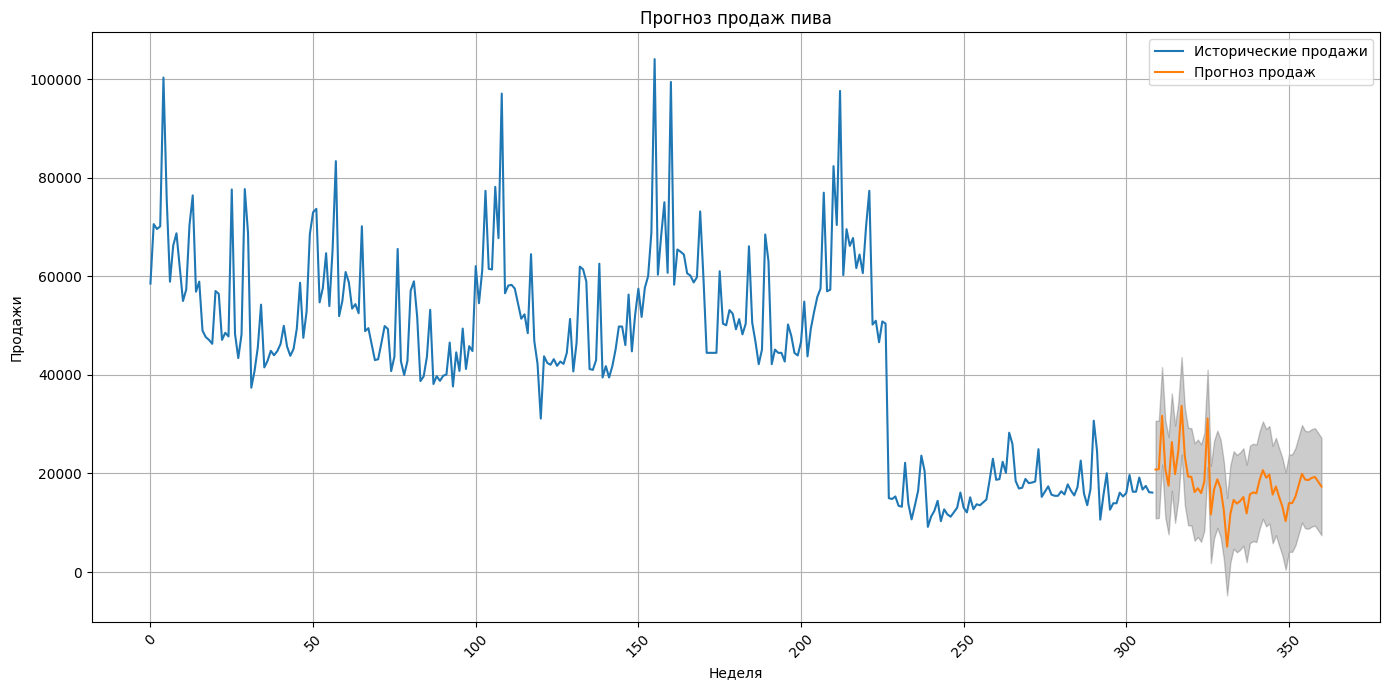

In [ ]:
exog = lagged_df.drop(columns=['move']).tail(forecast_periods)

# Добавление константы (если это необходимо)
exog = sm.add_constant(exog)

# Прогнозирование
forecast_mean = results.predict(exog=exog)

# Создание диапазона индексов для прогноза
last_index = lagged_df.index[-1]
forecast_index = np.arange(last_index + 1, last_index + 1 + forecast_periods)

# Визуализация прогноза
plt.figure(figsize=(14, 7))
plt.plot(lagged_df.index, lagged_df['move'], label="Исторические продажи")
plt.plot(forecast_index, forecast_mean, label="Прогноз продаж")
plt.fill_between(forecast_index,
                 forecast_mean - 1.96 * np.std(forecast_mean),
                 forecast_mean + 1.96 * np.std(forecast_mean),
                 color='k', alpha=0.2)
plt.title("Прогноз продаж пива")
plt.xlabel("Неделя")
plt.ylabel("Продажи")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Gradient Boosting